In [1]:
import kagglehub
path = kagglehub.dataset_download("paultimothymooney/blood-cells")
print("Path to dataset files:", path)

100%|██████████| 108M/108M [00:05<00:00, 19.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/blood-cells/versions/6


In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [12]:
# Data Path
base_path = '/root/.cache/kagglehub/datasets/paultimothymooney/blood-cells/versions/6/dataset2-master/dataset2-master/images/'
train_dir = os.path.join(base_path, 'TRAIN')
test_dir = os.path.join(base_path, 'TEST')

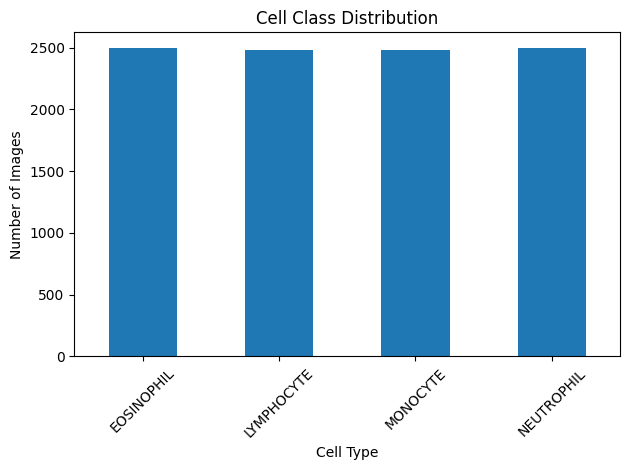

In [13]:
#Exploratory data analysis to visualise the class distribution
classes = sorted(os.listdir(train_dir))
image_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in classes}
df = pd.DataFrame.from_dict(image_counts, orient='index', columns=['Count'])
df.plot(kind='bar', legend=False, title='Cell Class Distribution')
plt.xlabel('Cell Type')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
# Image generators
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_data = train_gen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', subset='training'
)
val_data = train_gen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', subset='validation'
)
test_data = test_gen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False
)

Found 7968 images belonging to 4 classes.
Found 1989 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [15]:
# Build model with EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(len(classes), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [16]:
# Class weights to address imbalance
from sklearn.utils.class_weight import compute_class_weight
y_train_labels = train_data.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weights_dict = dict(enumerate(class_weights))

In [17]:
# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.2)
]

In [18]:
# Train model
history = model.fit(
    train_data, validation_data=val_data, epochs=20, class_weight=class_weights_dict, callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 218s 556ms/step - accuracy: 0.6263 - loss: 0.8978 - val_accuracy: 0.9211 - val_loss: 0.1916 - learning_rate: 1.0000e-04
Epoch 2/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 125s 503ms/step - accuracy: 0.9702 - loss: 0.0984 - val_accuracy: 0.9940 - val_loss: 0.0234 - learning_rate: 1.0000e-04
Epoch 3/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 124s 500ms/step - accuracy: 0.9867 - loss: 0.0403 - val_accuracy: 0.9960 - val_loss: 0.0129 - learning_rate: 1.0000e-04
Epoch 4/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 126s 506ms/step - accuracy: 0.9872 - loss: 0.0350 - val_accuracy: 0.9950 - val_loss: 0.0165 - learning_rate: 1.0000e-04
Epoch 5/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 125s 502ms/step - accuracy: 0.9933 - loss: 0.0212 - val_accuracy: 0.9975 - val_loss: 0.0070 - learning_rate: 1.0000e-04
Epoch 6/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 125s 500ms/step - accuracy: 0.9952 - loss: 0.0158 - val_accuracy: 0.9950 - val_loss: 0.0129 - learning_rate: 1.0000e-04
Epoch 7/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 

In [19]:
# Evaluate on test data
pred = model.predict(test_data)
y_pred = np.argmax(pred, axis=1)
y_true = test_data.classes
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=classes))

78/78 ━━━━━━━━━━━━━━━━━━━━ 18s 160ms/step
Classification Report:
               precision    recall  f1-score   support

  EOSINOPHIL       0.93      0.81      0.87       623
  LYMPHOCYTE       1.00      1.00      1.00       620
    MONOCYTE       1.00      0.71      0.83       620
  NEUTROPHIL       0.67      0.95      0.78       624

    accuracy                           0.87      2487
   macro avg       0.90      0.87      0.87      2487
weighted avg       0.90      0.87      0.87      2487



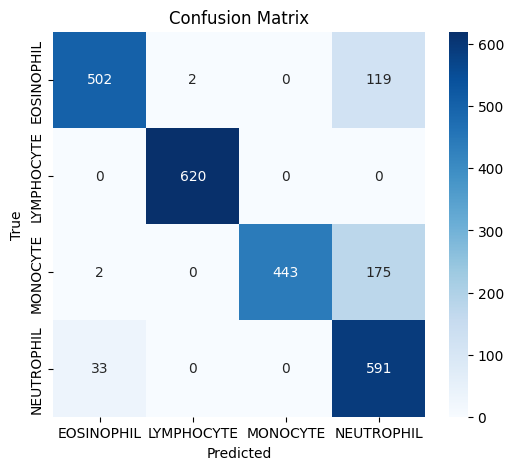

In [20]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()